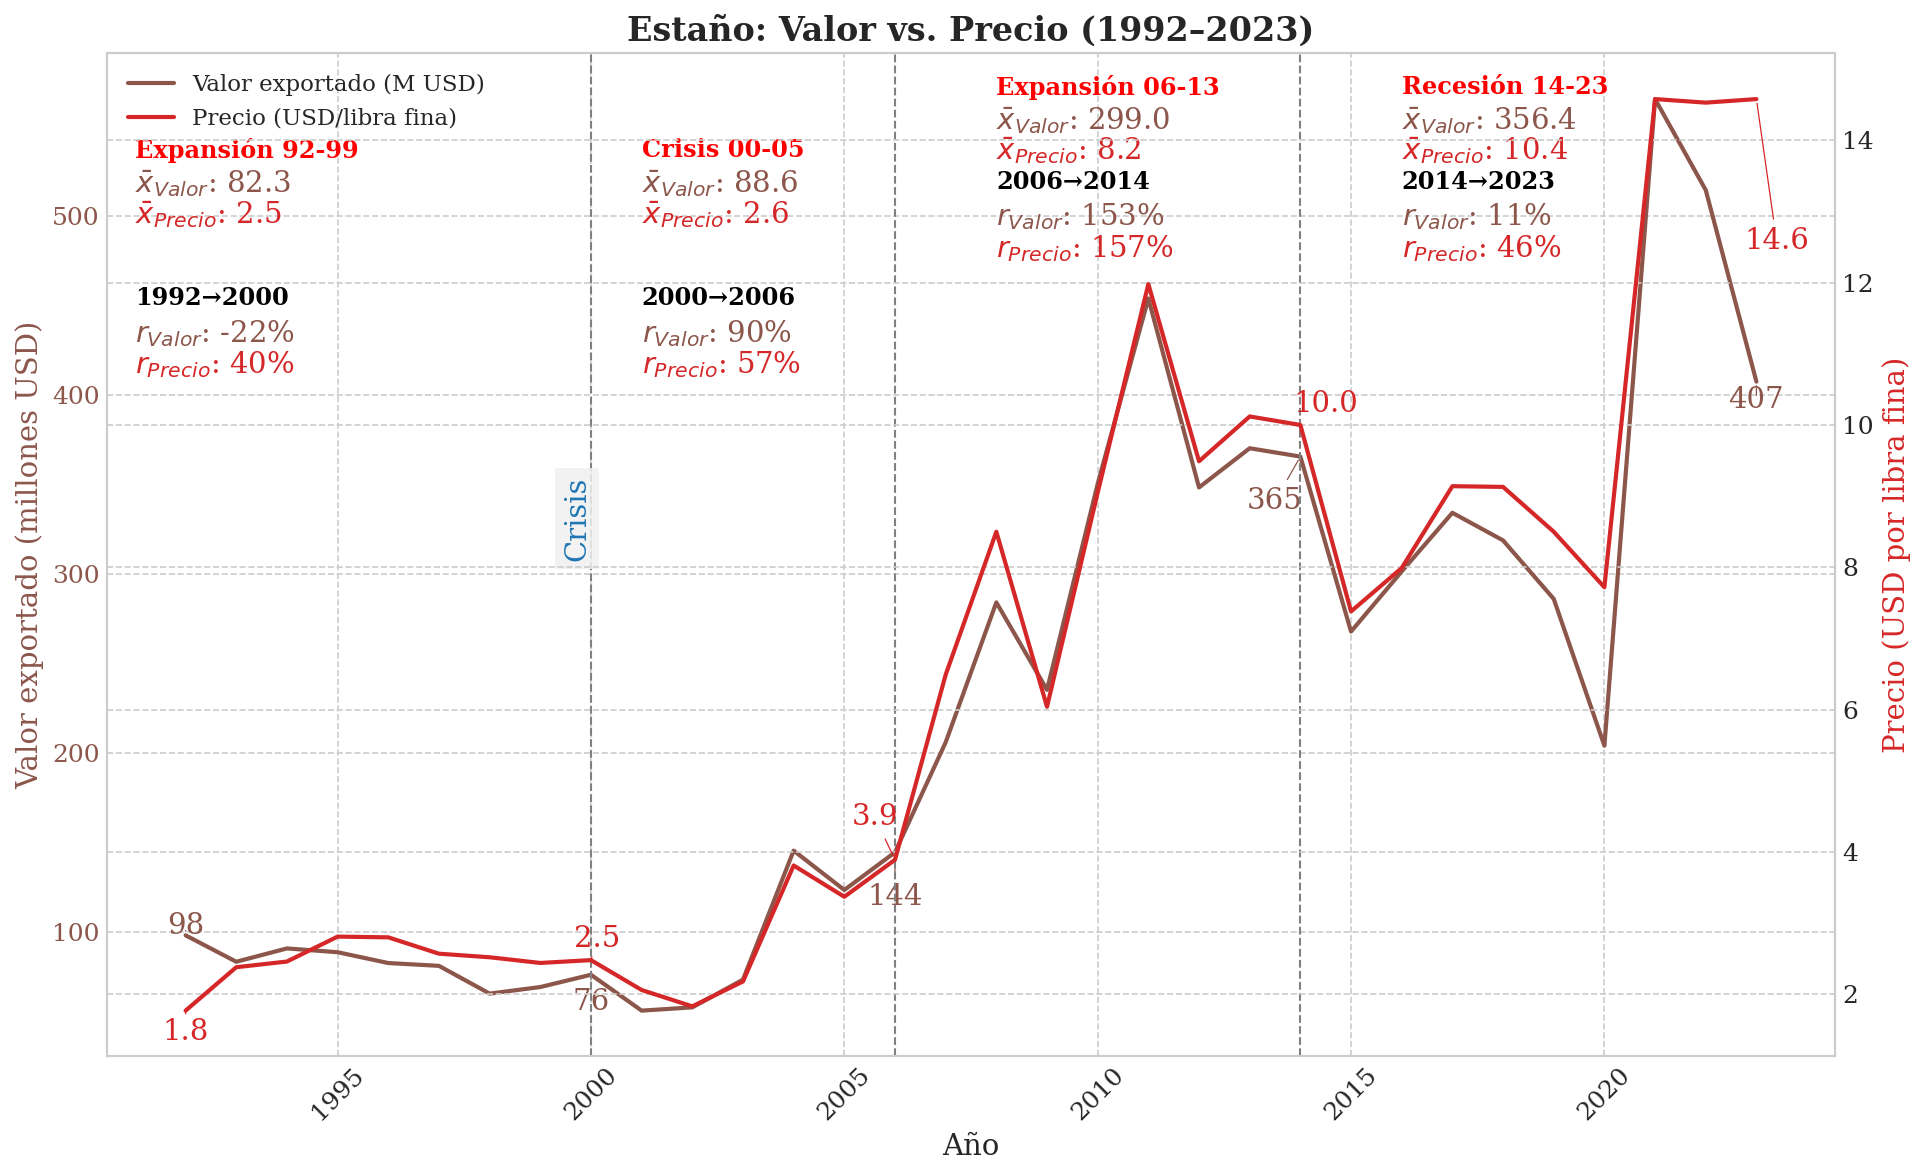

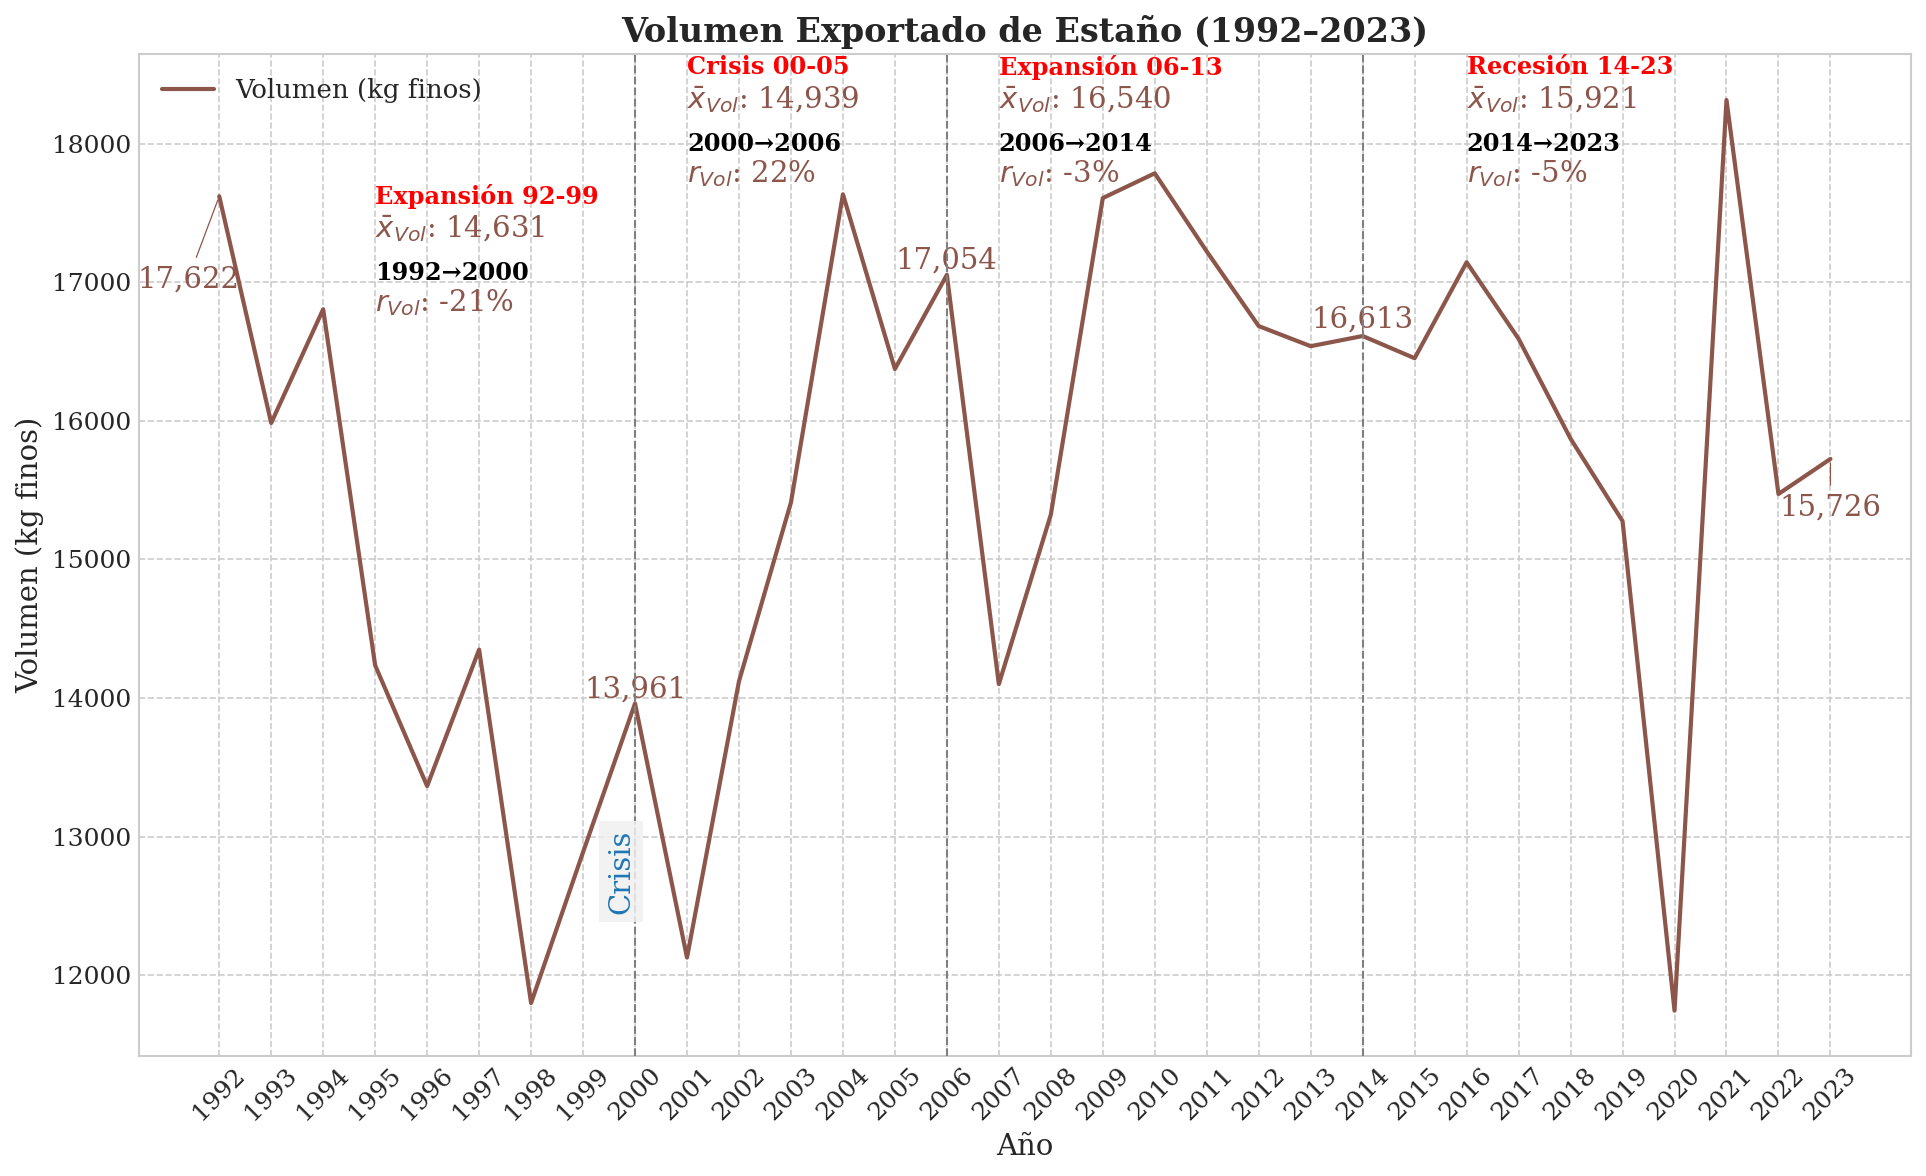

In [27]:
# ─────────────────────────────  PREPARACIÓN  ──────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi
)

# 0. Ciclos y carpetas
periods = {
    "Expansión 92-99": slice(1992, 1999),
    "Crisis 00-05":    slice(2000, 2005),
    "Expansión 06-13": slice(2006, 2013),
    "Recesión 14-23":  slice(2014, 2023),
}
output_dir = "../../../../assets/tesis/serie_completa/minerales"
os.makedirs(output_dir, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 16,   "axes.labelsize": 14,
    "grid.linestyle": "--", "lines.linewidth": 2,
    "figure.dpi": 150,      "savefig.bbox": "tight",
})

# 1. Datos ────────────────────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_estanio = (pd.read_sql(
        "SELECT año, estaño_volumen, estaño_valor "
        "FROM exportaciones_minerales_totales WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )
    df_precio = (pd.read_sql(
        "SELECT año, estaño AS precio_usd_lf "
        "FROM precio_oficial_minerales WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )

df = df_estanio.join(df_precio, how="inner")
df["estanio_valor_musd"] = df["estaño_valor"] / 1_000        # miles → millones
df.drop(columns="estaño_valor", inplace=True)

# ───────────────────────  GRÁFICA DUAL AXIS (valor-precio) ───────────────────────
cols   = ["estanio_valor_musd", "precio_usd_lf"]
abbr   = {"estanio_valor_musd": "Valor", "precio_usd_lf": "Precio"}
colors = {"estanio_valor_musd": "#8c564b", "precio_usd_lf": "#d62728"}  # marrón + rojo

cycle_stats = {n: df.loc[s, cols].mean().to_dict() for n, s in periods.items()}

hitos_v      = {2000: "Crisis", 2006: "Expansión", 2014: "Recesión"}
hitos_offset = {yr: .60 for yr in hitos_v}

anot_years = [1992, 2000, 2006, 2014, 2023]
annotation_offsets = {                     # ↙ ajusta tras ver la figura
    "estanio_valor_musd": {
        1992:(0,5), 2000:(0,-15), 2006:(0,-25),
        2014:(-0.5,-25), 2023:(0,-10)
    },
    "precio_usd_lf": {
        1992:(0,-0.3), 2000:(0.13,0.3), 2006:(-0.4,0.6),
        2014:(0.5,0.3), 2023:(0.4,-2)
    },
}
growth_periods        = [(1992,2000),(2000,2006),(2006,2014),(2014,2023)]
period_growth_offsets = {
    "1992-2000": (1991,0.78), "2000-2006":(2001,0.78),
    "2006-2014": (2008,0.89), "2014-2023":(2016,0.89)
}
cycle_text_offsets = {
    "Expansión 92-99": (1991,0.92),
    "Crisis 00-05":    (2001,0.92),
    "Expansión 06-13": (2008,0.98),
    "Recesión 14-23":  (2016,0.98),
}

fig, ax_val = plt.subplots(figsize=(13,8))
ax_price    = ax_val.twinx()

ax_val.plot(df.index, df["estanio_valor_musd"],
            label="Valor exportado (M USD)",
            color=colors["estanio_valor_musd"])
ax_price.plot(df.index, df["precio_usd_lf"],
              label="Precio (USD/libra fina)",
              color=colors["precio_usd_lf"])

add_hitos(ax_val, df.index, hitos_v, hitos_offset, line_kwargs={"lw":1})
add_cycle_means_multi(
    ax_val, cycle_stats, cycle_text_offsets,
    abbr, colors,
    line_spacing=df["estanio_valor_musd"].max()*0.03,
    value_fmt="{:,.1f}"
)
add_year_value_annotations(
    ax_val, df, anot_years, ["estanio_valor_musd"],
    {"estanio_valor_musd": annotation_offsets["estanio_valor_musd"]},
    {"estanio_valor_musd": colors["estanio_valor_musd"]},
    arrow_lw=0.6
)
add_year_value_annotations(
    ax_price, df, anot_years, ["precio_usd_lf"],
    {"precio_usd_lf": annotation_offsets["precio_usd_lf"]},
    {"precio_usd_lf": colors["precio_usd_lf"]},
    arrow_lw=0.6,
    value_fmt="{:,.1f}"
)
add_period_growth_annotations_multi(
    ax_val, df, growth_periods, cols,
    period_growth_offsets, colors, abbr
)

ax_val.set_title(f"Estaño: Valor vs. Precio ({df.index[0]}–{df.index[-1]})",
                 fontweight="bold")
ax_val.set_xlabel("Año")
ax_val.set_ylabel("Valor exportado (millones USD)",
                  color=colors["estanio_valor_musd"])
ax_price.set_ylabel("Precio (USD por libra fina)",
                    color=colors["precio_usd_lf"])
ax_val.tick_params(axis="y", labelcolor=colors["estanio_valor_musd"])
ax_val.tick_params(axis="x", rotation=45)

h,l   = ax_val.get_legend_handles_labels()
h2,l2 = ax_price.get_legend_handles_labels()
hl    = [(x,y) for x,y in zip(h+h2, l+l2) if not y.startswith('_')]
if hl: ax_val.legend(*zip(*hl), loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "estanio_valor_precio_dual_axis.png"), dpi=300)
plt.show()
# ─────────────────────────  GRÁFICA DE VOLUMEN ──────────────────────────
colors_vol = {"estaño_volumen": "tab:brown"}
abbr_vol   = {"estaño_volumen": "Vol"}

cycle_stats_vol = {
    n: df.loc[s, ["estaño_volumen"]].mean().to_dict()
    for n, s in periods.items()
}

hitos_v      = {2000: "Crisis", 2006: "Expansión", 2014: "Recesión"}
hitos_offset_v = {yr: 0.7 for yr in hitos_v}
 
annotation_offsets_vol = {
    "estaño_volumen": {
        1992:(-0.6,-600), 2000:(0,100), 2006:(0,100),
        2014:(0,120), 2023:(0,-350)
    }
}
period_growth_offsets_vol = {
    "1992-2000": (1995,0.92), "2000-2006":(2001,0.97),
    "2006-2014": (2007,0.97), "2014-2023":(2016,0.97)
}
cycle_text_offsets_vol = {
    "Expansión 92-99": (1995,0.95),
    "Crisis 00-05":    (2001,1),
    "Expansión 06-13": (2007,1),
    "Recesión 14-23":  (2016,1),
}

fig_v, ax_v = plt.subplots(figsize=(13,8))
ax_v.plot(df.index, df["estaño_volumen"],
          label="Volumen (kg finos)",
          color=colors_vol["estaño_volumen"])

add_hitos(ax_v, df.index, hitos_v, hitos_offset_v, line_kwargs={"lw":1})
y_min, y_max = ax_v.get_ylim()
line_spacing = (y_max - y_min) * 0.03   # 3 % del rango real

add_cycle_means_multi(
    ax_v, cycle_stats_vol, cycle_text_offsets_vol,
    abbr_vol, colors_vol,
    line_spacing=line_spacing
)
add_year_value_annotations(
    ax_v, df, anot_years, ["estaño_volumen"],
    annotation_offsets_vol, colors_vol, arrow_lw=0.6
)
add_period_growth_annotations_multi(
    ax_v, df, growth_periods,
    ["estaño_volumen"], period_growth_offsets_vol,
    colors_vol, abbr_vol,line_spacing_ratio=0.01
)

ax_v.set_title(f"Volumen Exportado de Estaño ({df.index[0]}–{df.index[-1]})",
               fontweight="bold")
ax_v.set_xlabel("Año")
ax_v.set_ylabel("Volumen (kg finos)")
ax_v.set_xticks(df.index[::max(1, len(df)//31)])
ax_v.tick_params(axis="x", rotation=45)
ax_v.legend(loc="upper left", fontsize=12.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "estanio_volumen.png"), dpi=300)
plt.show()

 